# Problem Formulation

### What is the relationship between air quality index and lung cancer incidence rates at the county level in the United States in 2024, and how is this relationship moderated by median household income and population age demographics?

# Data Acquisition

### Loading pacages

In [1]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns

print('### Python version: ' + __import__('sys').version)

### Python version: 3.13.11 (tags/v3.13.11:6278944, Dec  5 2025, 16:26:58) [MSC v.1944 64 bit (AMD64)]


### Load data files

In [2]:
FILE_AQI = 'data/annual_aqi_by_county_2025.csv'
FILE_CANCER = 'data/cancer_rate_by_county.csv'
FILE_POP = 'data/population_ages_by_county.csv'
FILE_INCOME = 'data/income_by_county.csv'
DB_NAME = 'aqi_project.db'

# Load Air Quality 
df_aqi = pd.read_csv(FILE_AQI)

# Load Cancer Rates. Header is on row 9
df_cancer = pd.read_csv(FILE_CANCER, skiprows=8)

# Load Population 
df_pop = pd.read_csv(FILE_POP)
df_pop = df_pop.drop(0) # Drop the description row

# Load Income
df_income = pd.read_csv(FILE_INCOME)
df_income = df_income.drop(0) # Drop the description row


## Data cleaning

### Population data

In [3]:

# Modify GEO_ID into 5-digit and store as fips in population data 
df_pop['fips'] = df_pop['GEO_ID'].apply(lambda x: str(x)[-5:] if pd.notnull(x) else None)

# Extract NAME into county and state
df_pop[['county_name', 'state_name']] = df_pop['NAME'].str.split(', ', expand=True)


In [4]:

# Select colums
df_demographics = df_pop[[
    'fips', 'county_name', 'state_name', 
    'S0101_C01_001E',  # total population
    'S0101_C01_032E',  # median Age
    'S0101_C01_002E',  # age under 5
    'S0101_C01_022E',  # age under 18
    'S0101_C01_024E',  # age from 15 to 44
    'S0101_C01_030E'   # age over 65
]].copy()

# Rename columns
df_demographics.columns = [
    'fips', 'county_name', 'state_name', 
    'total_pop', 'median_age', 
    'pop_under_5', 'pop_under_18', 'pop_15_to_44', 'pop_65_and_over'
]

# Convert all the new columns to numbers
cols_numeric = ['total_pop', 'median_age', 'pop_under_5', 'pop_under_18', 'pop_15_to_44', 'pop_65_and_over']
for col in cols_numeric:
    df_demographics[col] = pd.to_numeric(df_demographics[col], errors='coerce')


### Cancer data

In [5]:

df_cancer = df_cancer[df_cancer['FIPS'].notna()]

# Ensure FIPS is a 5-digit string
df_cancer['FIPS'] = df_cancer['FIPS'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(5)

# Select columns
df_health = df_cancer[[
    'FIPS', 
    'Age-Adjusted Incidence Rate([rate note]) - cases per 100,000', 
    'Average Annual Count'
]].copy()

# Rename columns 
df_health.columns = ['fips', 'incidence_rate', 'avg_annual_count']

# Convert both columns to numeric 
df_health['incidence_rate'] = pd.to_numeric(df_health['incidence_rate'], errors='coerce')
df_health['avg_annual_count'] = pd.to_numeric(df_health['avg_annual_count'], errors='coerce')


### Air quality data

In [6]:

df_aqi['key'] = df_aqi['County'] + "_" + df_aqi['State']
df_demographics['key'] = df_demographics['county_name'].str.replace(' County', '').str.replace(' Parish', '') + "_" + df_demographics['state_name']

# Merge AQI with demographics to attach fips
df_aqi_merged = pd.merge(df_aqi, df_demographics[['fips', 'key']], on='key', how='left')

df_aqi_merged = df_aqi_merged.dropna(subset=['fips'])

df_aqi_final = df_aqi_merged[[
    'fips', 
    'Year', 
    'Days with AQI', 
    'Good Days',
    'Moderate Days',
    'Unhealthy for Sensitive Groups Days',
    'Unhealthy Days',
    'Very Unhealthy Days',
    'Hazardous Days',
    'Max AQI',
    '90th Percentile AQI',
    'Median AQI',
    'Days CO',
    'Days NO2',
    'Days Ozone',
    'Days PM2.5',
    'Days PM10'
]].copy()



df_aqi_final.columns = [
    'fips', 
    'year', 
    'days_aqi', 
    'good_days', 
    'moderate_days', 
    'unhealthy_group_days',
    'unhealthy_days',
    'very_unhealthy_days',
    'hazardous_days',
    'max_aqi',
    'aqi_p90',
    'median_aqi',
    'days_co',
    'days_no2',
    'days_ozone',
    'days_pm25',
    'days_pm10'
]



### Income data

In [8]:

df_income['fips'] = df_income['GEO_ID'].apply(lambda x: str(x)[-5:] if pd.notnull(x) else None)

df_income['median_income'] = pd.to_numeric(df_income['B19013_001E'], errors='coerce')

# Filter down to just the columns we want for the database
df_income_final = df_income[['fips', 'median_income']].copy()


# Data Acquisition II (database)

### Create database

In [9]:
# Create database
print(f"Creating SQLite database: {DB_NAME}...")
conn = sqlite3.connect(DB_NAME)
conn.execute("PRAGMA foreign_keys = ON;")
cursor = conn.cursor()


Creating SQLite database: aqi_project.db...


### Create counties table

In [10]:
# Create counties table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS counties (
        fips TEXT PRIMARY KEY,
        county_name TEXT,
        state_name TEXT
    )
''')



### Create demographics table

In [11]:
# Create demographics table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS demographics (
        id INTEGER PRIMARY KEY,
        fips TEXT,
        total_pop INTEGER,
        median_age REAL,
        pop_under_5 REAL,
        pop_under_18 REAL,
        pop_15_to_44 REAL,
        pop_65_and_over REAL,
        FOREIGN KEY(fips) REFERENCES counties(fips)
    )
''')



### Create air_quality table

In [12]:
# Create air_quality table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS air_quality (
        id INTEGER PRIMARY KEY,
        fips TEXT,
        year INTEGER,
        days_aqi INTEGER, 
        good_days INTEGER, 
        moderate_days INTEGER, 
        unhealthy_group_days INTEGER,
        unhealthy_days INTEGER,
        very_unhealthy_days INTEGER,
        hazardous_days INTEGER,
        max_aqi INTEGER,
        aqi_p90 INTEGER,
        median_aqi INTEGER,
        days_co INTEGER,
        days_no2 INTEGER,
        days_ozone INTEGER,
        days_pm25 INTEGER,
        days_pm10 INTEGER,
        FOREIGN KEY(fips) REFERENCES counties(fips)
    )
''')



### Create health table

In [13]:
# Create health table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS health (
        id INTEGER PRIMARY KEY,
        fips TEXT,
        county TEXT,
        state TEXT,
        incidence_rate REAL,
        avg_annual_count INTEGER,
        FOREIGN KEY(fips) REFERENCES counties(fips)
    )
''')

### Create income table

In [14]:
# Create income table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS income (
        id INTEGER PRIMARY KEY,
        fips TEXT,
        median_income REAL,
        FOREIGN KEY(fips) REFERENCES counties(fips)
    )
''')


## Insert data

In [15]:

# Insert county and state data into counties table
df_demographics[[
    'fips', 'county_name', 'state_name'
]].drop_duplicates().to_sql('counties', conn, if_exists='append', index=False)


# Insert population data into demographics table
df_demographics[[
    'fips', 
    'total_pop', 
    'median_age', 
    'pop_under_5', 
    'pop_under_18', 
    'pop_15_to_44', 
    'pop_65_and_over'
]].to_sql('demographics', conn, if_exists='append', index=False)


# Insert air quality data into air_quality table
df_aqi_final.to_sql('air_quality', conn, if_exists='append', index=False)


# Find fips exist in counties
valid_fips = set(pd.read_sql("SELECT fips FROM counties", conn)['fips'])
# Filter out health data whose fips isn't in counties
df_health = df_health[df_health['fips'].isin(valid_fips)]
# Insert cancer data into health table
df_health.to_sql('health', conn, if_exists='append', index=False)


# Insert data into the income table
df_income_final.to_sql('income', conn, if_exists='append', index=False)

print("Database populated successfully.")


Database populated successfully.


# Data Exploration

## 1. Correlation Heatmap

### The heatmap shows that the corrleation bwtween mdeian air quality and cancer rate, and the corrleation bwtween mdeian air quality and median income are extremely low. It suggests that public health outcomes like cancer are highly multifactorial, factors like median age, genetics, and historical pollution exposure will likely play larger roles than a single year's AQI snapshot. Furthermore, the weak correlation between income and AQI indicates that geographical environmental hazards, like wildfires or industrial zones can impact regions regardless of their median wealth.

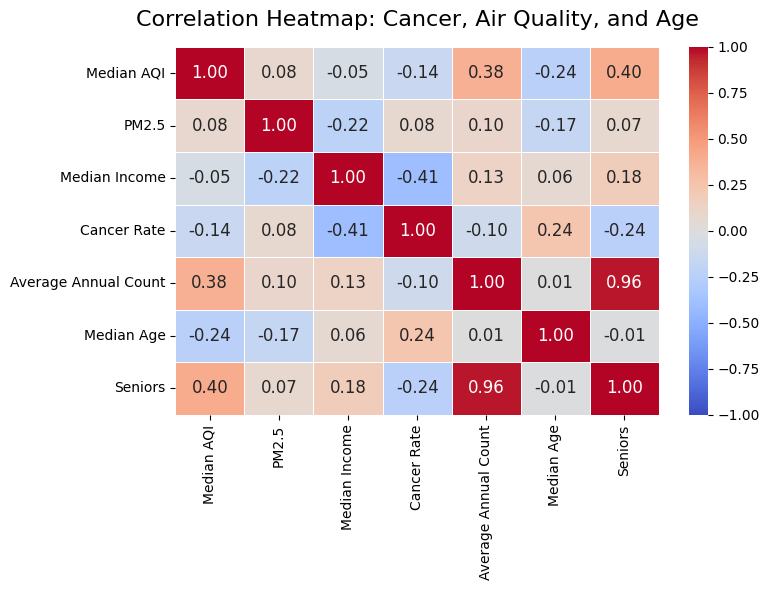

In [16]:

conn = sqlite3.connect('aqi_project.db')

query = """
    SELECT 
        a.median_aqi AS 'Median AQI', 
        a.days_pm25 AS 'PM2.5', 
        i.median_income AS 'Median Income',
        h.incidence_rate AS 'Cancer Rate', 
        h.avg_annual_count AS 'Average Annual Count',
        d.median_age AS 'Median Age',
        d.pop_65_and_over AS 'Seniors'
    FROM counties c
    JOIN health h ON c.fips = h.fips
    JOIN air_quality a ON c.fips = a.fips
    JOIN demographics d ON c.fips = d.fips
    JOIN income i ON c.fips = i.fips
    WHERE a.median_aqi IS NOT NULL AND h.incidence_rate IS NOT NULL
"""
df_heatmap = pd.read_sql(query, conn)
conn.close()

# Calculate the correlation matrix
corr_matrix = df_heatmap.corr()

# 3. Plot the Heatmap
plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_matrix, 
    annot=True,        
    cmap='coolwarm',    
    fmt=".2f",         
    vmin=-1, vmax=1,  
    linewidths=0.5, 
    annot_kws={"size": 12}
)

plt.title('Correlation Heatmap: Cancer, Air Quality, and Age', fontsize=16, pad=15)
plt.tight_layout()

# Save the image
plt.savefig('correlation_heatmap.png')

## 2. Box Plot

### This visualization highlights the variance in environmental stability. While the median AQI might be similar across tiers, the "Low Income" tier typically exhibits a wider box. This suggests that lower-income counties are subject to much more volatile and unpredictable spikes in poor air quality compared to the more stable environments of high-income counties.

C:\Users\hkwan\AppData\Local\Temp\ipykernel_137012\3119135090.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


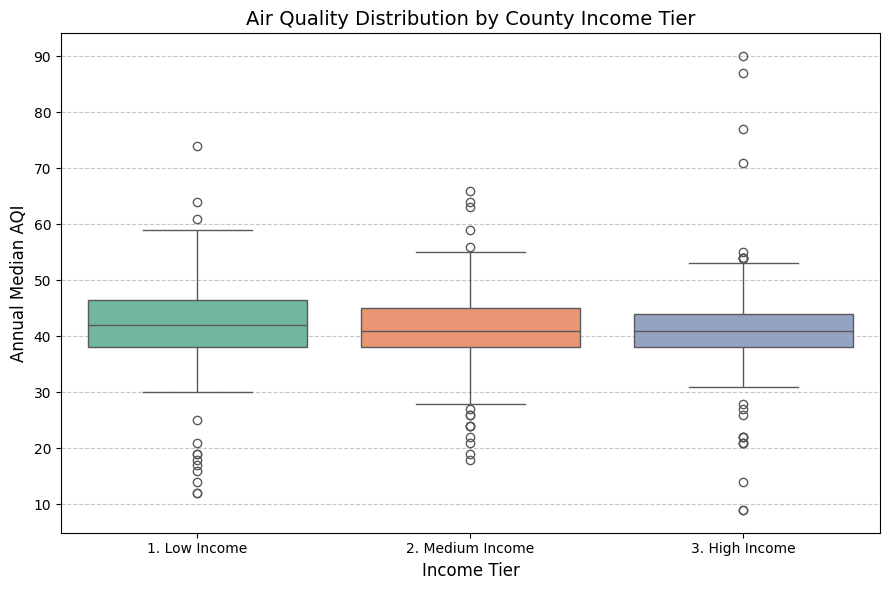

In [17]:

conn = sqlite3.connect('aqi_project.db')

query = """
    SELECT 
        c.fips, c.county_name, c.state_name,
        a.median_aqi,
        i.median_income,
        d.total_pop,
        h.incidence_rate
    FROM counties c
    JOIN air_quality a ON c.fips = a.fips
    JOIN income i ON c.fips = i.fips
    JOIN demographics d ON c.fips = d.fips
    JOIN health h ON c.fips = h.fips
    WHERE a.median_aqi IS NOT NULL 
      AND i.median_income IS NOT NULL 
      AND h.incidence_rate IS NOT NULL
"""
df_boxplot = pd.read_sql(query, conn)
conn.close()

# Split income into 3 equal buckets
df_boxplot['income_tier'] = pd.qcut(
    df_boxplot['median_income'], 
    q=3, 
    labels=['1. Low Income', '2. Medium Income', '3. High Income']
)

# Draw the Box Plot
plt.figure(figsize=(9, 6))
sns.boxplot(
    x='income_tier', 
    y='median_aqi', 
    data=df_boxplot, 
    palette='Set2'
)

# Format and Save
plt.title('Air Quality Distribution by County Income Tier', fontsize=14)
plt.xlabel('Income Tier', fontsize=12)
plt.ylabel('Annual Median AQI', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('boxplot_income_vs_aqi.png')

## 3. Histogram

### The data reveals that on the left side of the graph demonstrates that the vast majority of U.S. counties maintain a healthy, low Median AQI, typically under 45. However, from the right, we can see there are some extreme outlier counties that suffer from severe environmental pollution.

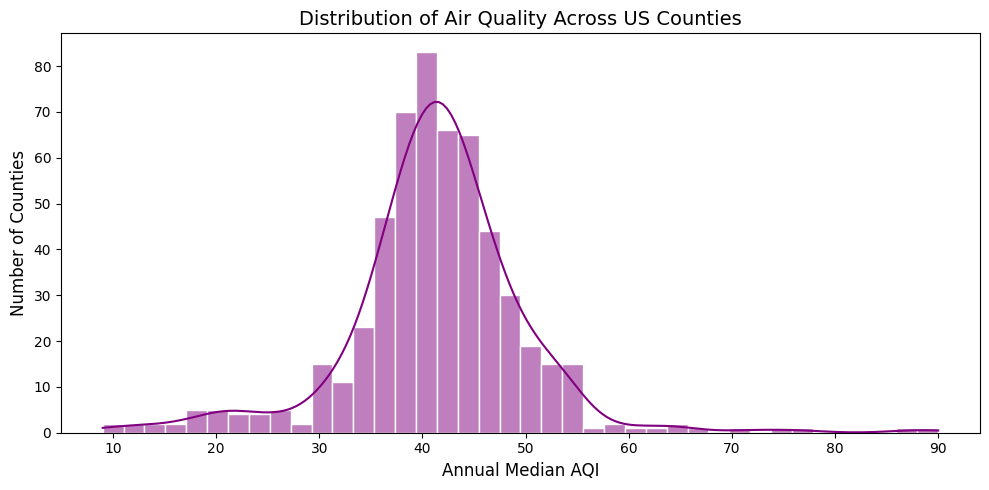

In [18]:

conn = sqlite3.connect('aqi_project.db')

query = """
    SELECT 
        c.fips, c.county_name, c.state_name,
        a.median_aqi,
        i.median_income,
        d.total_pop,
        h.incidence_rate
    FROM counties c
    JOIN air_quality a ON c.fips = a.fips
    JOIN income i ON c.fips = i.fips
    JOIN demographics d ON c.fips = d.fips
    JOIN health h ON c.fips = h.fips
    WHERE a.median_aqi IS NOT NULL 
      AND i.median_income IS NOT NULL 
      AND h.incidence_rate IS NOT NULL
"""
df_histogram = pd.read_sql(query, conn)
conn.close()

plt.figure(figsize=(10, 5))

# Draw the Histogram with a Density curve
sns.histplot(
    df_histogram['median_aqi'], 
    bins=40, 
    kde=True, 
    color='purple', 
    edgecolor='white'
)

# Format and Save
plt.title('Distribution of Air Quality Across US Counties', fontsize=14)
plt.xlabel('Annual Median AQI', fontsize=12)
plt.ylabel('Number of Counties', fontsize=12)

plt.tight_layout()
plt.savefig('histogram_aqi_distribution.png')

## 4. Scatter Plot

### A moderate correlation here indicates that income alone does not perfectly predict air quality, prompting the need to look at other variables such as population density.

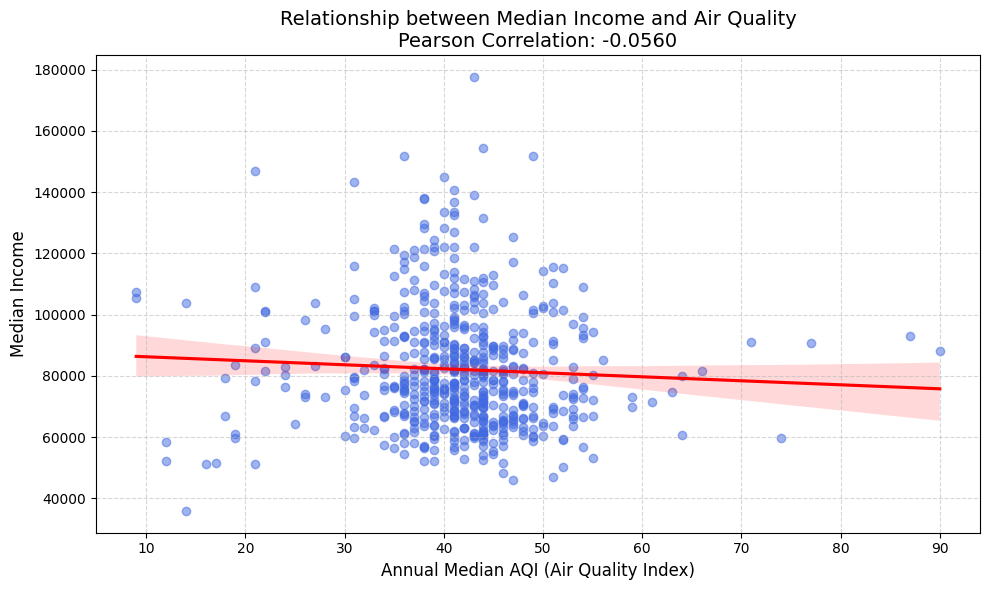

In [19]:

conn = sqlite3.connect('aqi_project.db')

query = """
    SELECT 
        a.median_aqi,
        i.median_income
    FROM air_quality a
    JOIN income i ON a.fips = i.fips 
    WHERE a.median_aqi IS NOT NULL 
      AND i.median_income IS NOT NULL 
"""

df_scatter_plot = pd.read_sql(query, conn)
conn.close()

# Calculate the correlation coefficient
correlation = df_scatter_plot['median_aqi'].corr(df_scatter_plot['median_income'])

# Create the Scatter Plot
plt.figure(figsize=(10, 6))

# Plot the dots and the trendline using Seaborn
sns.regplot(
    x='median_aqi', 
    y='median_income', 
    data=df_scatter_plot, 
    scatter_kws={'alpha': 0.5, 'color': 'royalblue'}, 
    line_kws={'color': 'red'}                       
)

# Add Labels and Title
plt.title(f'Relationship between Median Income and Air Quality\nPearson Correlation: {correlation:.4f}', fontsize=14)
plt.xlabel('Annual Median AQI (Air Quality Index)', fontsize=12)
plt.ylabel('Median Income', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Save the plot to your folder
plt.tight_layout()
plt.savefig('aqi_vs_income.png')